## Overlapping Labels

In this exercise, we're going to **simulate** the issue we encounter when training machine learning models using targets that are returns that _overlap in time_. The core issue is that these labels are correlated and in fact _redundant_. We'll see what impact this has on our machine learning algorithm, and we'll have the opportunity to implement some of the solutions to the problem that we described in the lectures, and will later encounter in the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
import warnings

warnings.filterwarnings('ignore')

## Load data
Let's load up a small dataset of artificial "toy" data that we can play with. The columns in these data are `A`, `B`, `C` and `D`. We will use the `E` column as targets.

In [3]:
df = pd.read_csv('dependent_labels_dataset.csv', index_col = 0)

In [4]:
df.head()

,A,B,C,D,E
t,,,,,
1.0,0.780067,-1.139543,0.298152,0.412867,3
2.0,0.521061,-0.680001,0.148710,0.461035,3
3.0,0.425336,-0.620970,0.099168,0.409145,3
4.0,0.696707,-0.666513,0.099526,0.477195,3
5.0,-0.059698,-0.220574,0.249784,0.465186,3


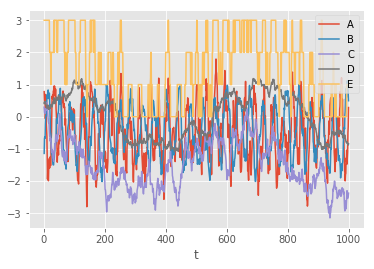

In [5]:
df.plot()

In [6]:
df.shape

(1000, 5)

## Create redundancy in the data
In order to illustrate the effect of redundancy in the data, we are going to deliberately create an extreme version of this condition by **duplicating each row in the data 5 times**, using the function `create_redundant_data` below.

In [7]:
num_duplicates = 5

In [8]:
def create_redundant_data(df, num_duplicates):
    """
    From the existing dataset, create a new dataset in which every original row is exactly duplicated `num_duplicates` times. 
    Re-order this new dataset according to the order of the original index.

    Parameters
    ----------
    df : pandas DataFrame
        The original dataset.
    
    Returns
    -------
    redundant_df : pandas DataFrame
        The new, redundant dataset.
    """
    
    # TODO: Implement
    redundant_df = df.copy()
    for i in range(num_duplicates - 1):
        redundant_df = redundant_df.append(df)
    
    redundant_df.sort_index(axis=0, level='t', inplace=True)
    
    return redundant_df

In [9]:
redundant_df = create_redundant_data(df, num_duplicates)

In [10]:
redundant_df.head(20)

,A,B,C,D,E
t,,,,,
1.0,0.780067,-1.139543,0.298152,0.412867,3
1.0,0.780067,-1.139543,0.298152,0.412867,3
1.0,0.780067,-1.139543,0.298152,0.412867,3
1.0,0.780067,-1.139543,0.298152,0.412867,3
1.0,0.780067,-1.139543,0.298152,0.412867,3
2.0,0.521061,-0.680001,0.148710,0.461035,3
2.0,0.521061,-0.680001,0.148710,0.461035,3
2.0,0.521061,-0.680001,0.148710,0.461035,3
2.0,0.521061,-0.680001,0.148710,0.461035,3


In [11]:
redundant_df.shape

(5000, 5)

Create a function for scoring the model.

In [12]:
def model_score(m, X_train, y_train, X_valid, y_valid):
    '''
    Take in the model and training and validation datasets, and return the training accuracy score, validation
    accuracy score, and out-of-bag score. Furthermore, print each of these results.
    
    Parameters
    ----------
    m : RandomForestClassifier instance
        The trained model.
        
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
        
    X_valid : pandas DataFrame
        The validation features.
        
    y_valid : pandas Series
        The validation labels.
    
    Returns
    -------
    train_score : float
        The mean training accuracy.
        
    valid_score : float
        The mean validation accuracy.
        
    oob_score : float
        The out-of-bag score.
    
    '''

    # TODO: Implement
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    oob_score = m.oob_score_
    
    print(f'train: {train_score}, oob: {oob_score}, valid: {valid_score}')
    
    return train_score, valid_score, oob_score

## Split data into train, valid and test sets

In [13]:
def make_splits(df, features, target, split_valid=0.20, split_test=0.20):
    temp = df.dropna()
    
    X = temp[features].copy()
    y = temp[target].copy()

    train_end = int(X.shape[0] * (1 - split_valid - split_test))
    valid_end = train_end + int(X.shape[0] * split_valid)

    X_train, X_valid, X_test = X.iloc[:train_end,], X.iloc[(train_end + 1):valid_end,], X.iloc[(valid_end + 1):]
    y_train, y_valid, y_test = y.iloc[:train_end,], y.iloc[(train_end + 1):valid_end,], y.iloc[(valid_end + 1):]
    
    return X, X_train, X_valid, X_test, y_train, y_valid, y_test

In [14]:
features = ['A', 'B', 'C', 'D']

In [15]:
X, X_train, X_valid, X_test, y_train, y_valid, y_test = make_splits(
    redundant_df,
    features,
    'E'
)

## Train one tree, take a look at it

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
def instantiate_and_fit_one_tree(X_train, y_train):
    """
    Instantiate a single decision tree and fit it on the training data. Return the fitted classifier.
    
    Parameters
    ----------
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
    
    Returns
    -------
    clf : DecisionTreeClassifier
        The fitted classifier instance.
    """
    
    # TODO: Implement
    # Can do this with a DecisionTreeClassifier or with a RandomForestClassifier, with n_estimators=1
    clf = DecisionTreeClassifier(
        max_depth=3, 
        max_features=None, 
        criterion='entropy', 
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    return clf

In [18]:
clf = instantiate_and_fit_one_tree(X_train, y_train)

In [19]:
! pip install graphviz

In [20]:
import graphviz
from sklearn.tree import export_graphviz

def export_graph(classifier, feature_names):
    """
    First, export the dot data from the fitted classifier. Then, create a graphviz Source object from the dot data,
    and return it.

    Parameters
    ----------
    classifier : DecisionTreeClassifier
        The single decision tree you created and fit above.
    
    Returns
    -------
    graph : graphviz Source object
        The Source object created with the graph information.
    """
    
    # TODO: Implement
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=features,
        filled=True, 
        rounded=True,
        special_characters=True,
        rotate=False
    )
    
    graph = graphviz.Source(dot_data);
    return graph

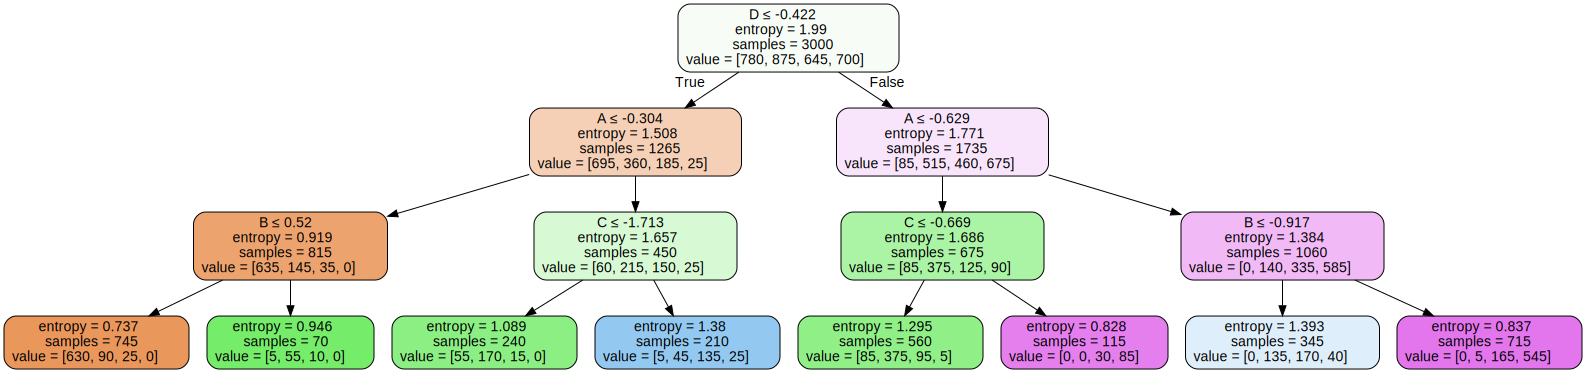

In [21]:
# display the single decision tree graph in the notebook
graph = export_graph(clf, features)
graph

## Redundant labels
Let's see what happens when we train a full random forest on these redundant data.

In [22]:
def instantiate_and_fit_a_rf(n_estimators, X_train, y_train, min_samples_leaf=5):
    """
    Instantiate a random forest classifier and fit it on the training data. Return the fitted classifier.
    Make sure you use bootstrapping and calculate an out-of-bag score. Set `random_state` equal to an integer so that
    when you fit the model again you get the same result. 
    
    Parameters
    ----------
    n_estimators : int
        The number of trees.
    
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
    
    Returns
    -------
    clf : RandomForestClassifier
        The fitted classifier instance.
    """
    
    # TODO: Implement
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features='sqrt',
        min_samples_leaf=min_samples_leaf,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    return clf

In [23]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250]

for trees in tqdm(tree_sizes):
    clf_red = instantiate_and_fit_a_rf(trees, X_train, y_train)
    
    tr, va, oob = model_score(clf_red, X_train, y_train, X_valid, y_valid)
    train_score.append(tr); valid_score.append(va); oob_score.append(oob)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

train: 1.0, oob: 0.9796666666666667, valid: 0.6446446446446447
train: 1.0, oob: 1.0, valid: 0.6546546546546547
train: 1.0, oob: 1.0, valid: 0.6646646646646647
train: 1.0, oob: 1.0, valid: 0.6596596596596597



In [24]:
def plot_results(tree_sizes, train_score, oob_score, valid_score, title, y_range):
    plt.plot(tree_sizes, train_score, 'xb-');
    plt.plot(tree_sizes, oob_score, 'xg-');
    plt.plot(tree_sizes, valid_score, 'xr-');
    plt.title(title);
    plt.xlabel('Number of Trees');
    plt.ylabel('Accuracy')
    plt.legend(['train','oob', 'valid'])
    plt.ylim(y_range[0], y_range[1]);

In [25]:
y_range = []
y_range.append(0.45)
y_range.append(1.005)

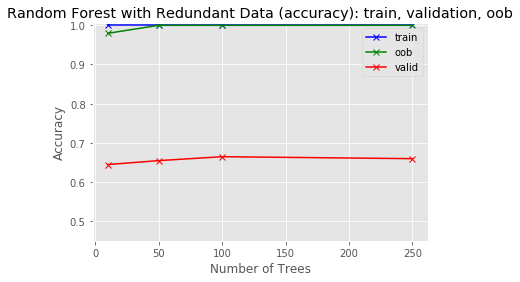

In [26]:
plot_results(tree_sizes, train_score, oob_score, valid_score, 'Random Forest with Redundant Data (accuracy): train, validation, oob', y_range)

What you can see from this run is that the OOB score virtually tracks the training score because the OOB data contains the same information as the training data. The validation score, calculated on unseen data, is much lower.

## Solution #1: use every 5th row
In this section, implement the first solution to the redundancy issue by sub-sampling every 5th row of the data.

In [27]:
def create_subsampled_dataset(num_duplicates, X_train, y_train):
    """
    Create the sub-sampled dataset according to the first solution proposed to the problem of overlapping labels. 
    
    Parameters
    ----------
    num_duplicates : int
        The number of duplications made earlier.
    
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
    
    Returns
    -------
    X_train_sub : pandas DataFrame
        The training features, subsampled.
        
    y_train_sub : pandas Series
        The training labels, subsampled.
    """
    
    # TODO: Implement
    # pandas slide: all rows and columns with step = 5
    X_train_sub = X_train[::5]
    y_train_sub = y_train[::5]
    
    return X_train_sub, y_train_sub

In [28]:
X_train_sub, y_train_sub = create_subsampled_dataset(5, X_train, y_train)

In [29]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250]

for trees in tqdm(tree_sizes):
    clf_sub = instantiate_and_fit_a_rf(trees, X_train_sub, y_train_sub)
    
    tr, va, oob = model_score(clf_sub, X_train_sub, y_train_sub, X_valid, y_valid)
    train_score.append(tr); valid_score.append(va); oob_score.append(oob)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

train: 0.9383333333333334, oob: 0.7766666666666666, valid: 0.6146146146146146
train: 0.965, oob: 0.8316666666666667, valid: 0.6546546546546547
train: 0.9616666666666667, oob: 0.8383333333333334, valid: 0.6046046046046046
train: 0.96, oob: 0.845, valid: 0.6346346346346347



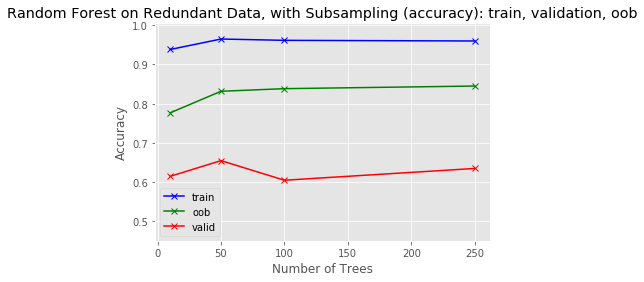

In [30]:
plot_results(tree_sizes, train_score, oob_score, valid_score, 'Random Forest on Redundant Data, with Subsampling (accuracy): train, validation, oob', y_range)

In the case of our artificial dataset, this completely removes the redundancy.

## Solution #2: reduce bag size
In this section, implement the second solution we proposed—to use `BaggingClassifier` to randomly draw a smaller fraction of the original dataset's rows when creating each tree's dataset.

In [31]:
from sklearn.ensemble import BaggingClassifier

In [32]:
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features='sqrt',
    min_samples_leaf=5
)

In [33]:
def instantiate_and_fit_a_BaggingClassifier(n_estimators, base_estimator, X_train, y_train, max_samples=0.2):
    """
    Instantiate a Bagging Classifier and fit it on the training data. Return the fitted classifier.
    Make sure you use bootstrapping and calculate an out-of-bag score. Set `random_state` equal to an integer so that
    when you fit the model again you get the same result. 
    
    Parameters
    ----------
    n_estimators : int
        The number of trees.
        
    base_estimator : DecisionTreeClassifier
        The base estimator of the BaggingClassifier.
        
    max_samples : float
        The percentage of the number of original rows to draw for each bag.
    
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
    
    Returns
    -------
    clf : BaggingClassifier
        The fitted classifier instance.
    """
    
    # TODO: Implement
    clf = BaggingClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    return clf

In [34]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250]

for trees in tqdm(tree_sizes):
    clf_bag = instantiate_and_fit_a_BaggingClassifier(trees, base_clf, X_train, y_train)
    
    tr, va, oob = model_score(clf_bag, X_train, y_train, X_valid, y_valid)
    train_score.append(tr); valid_score.append(va); oob_score.append(oob)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

train: 0.9466666666666667, oob: 0.922, valid: 0.6346346346346347
train: 0.9733333333333334, oob: 0.9603333333333334, valid: 0.6246246246246246
train: 0.975, oob: 0.9576666666666667, valid: 0.6396396396396397
train: 0.97, oob: 0.9636666666666667, valid: 0.6446446446446447



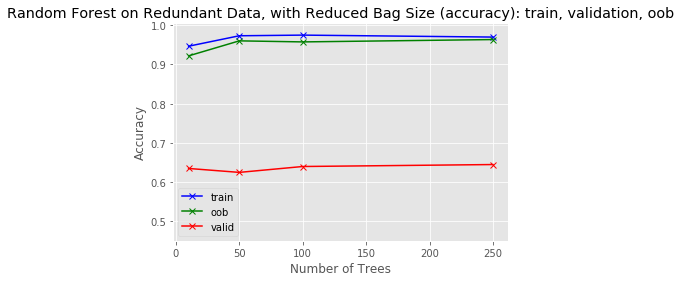

In [35]:
plot_results(tree_sizes, train_score, oob_score, valid_score, 'Random Forest on Redundant Data, with Reduced Bag Size (accuracy): train, validation, oob', y_range)

As you can see, in the case of this small artificial dataset, this helped but didn't fully resolve the problem. The OOB score still vastly overestimates the validation score.

## Solution #3: bagged non-overlapping labels
Finally, let's look at the last solution we proposed to this problem. We'll do this one for you for this small exercise, but you'll have the opportunity to work on it yourself later. We will fit separate models on each non-redundant subset of data, and then ensemble them together.

In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import has_fit_parameter, check_is_fitted
from sklearn.utils.metaestimators import _BaseComposition
from sklearn.utils import Bunch

In [37]:
class NoOverlapVoter(VotingClassifier):
    def __init__(self, base_estimator, overlap_increment=5):
        self.est_list = []
        for i in range(overlap_increment):
            self.est_list.append(('clf'+str(i), clone(base_estimator)))
        self.overlap_increment = overlap_increment
        super().__init__(
            self.est_list,
            voting='soft'
        )
    
    @property
    def oob_score_(self):
        oob = 0
        for clf in self.estimators_:
            oob = oob + clf.oob_score_
        return oob / len(self.estimators_)
    
    def fit(self, X, y, sample_weight=None):
        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)

        self.estimators_ = []
        for i in range(self.overlap_increment):
            self.estimators_.append(
                clfs[i].fit(X[i::self.overlap_increment], transformed_y[i::self.overlap_increment])
            )
        
        self.named_estimators_ = Bunch(**dict())
        for k, e in zip(self.estimators, self.estimators_):
            self.named_estimators_[k[0]] = e
        return self

In [38]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250]

for trees in tqdm(tree_sizes):
    clf = RandomForestClassifier(
        n_estimators=trees,
        max_features='sqrt',
        min_samples_leaf=5,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=0
    )
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train.reset_index()[['A','B','C','D']], y_train)
    t, v, o = model_score(clf_nov, X_train, y_train, X_valid, y_valid)
    train_score.append(t); valid_score.append(v); oob_score.append(o)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

train: 0.9466666666666667, oob: 0.7816666666666666, valid: 0.6296296296296297
train: 0.965, oob: 0.835, valid: 0.6596596596596597
train: 0.9666666666666667, oob: 0.8416666666666666, valid: 0.6696696696696697
train: 0.96, oob: 0.85, valid: 0.6646646646646647



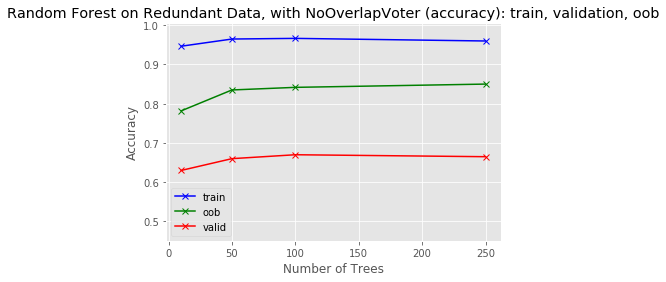

In [39]:
plot_results(tree_sizes, train_score, oob_score, valid_score, 'Random Forest on Redundant Data, with NoOverlapVoter (accuracy): train, validation, oob', y_range)

So in the case of this artificial dataset, this method performs as well as the first method, but this makes sense because each of the separate classifiers has the exact same information as the others. Combining them together should not yield much performance enhancement. You can then compare this result to the result that you'll see in the project, when this method is applied to real financial data.

## Check the performance on test set

Finally, let's look at the performance of the third method on the held-out test set. For this, we'll train on all of the previous training and validation data.

In [40]:
X, X_train, X_valid, X_test, y_train, y_valid, y_test = make_splits(
    redundant_df,
    features,
    'E',
    split_valid = 0
)

In [41]:
clf = RandomForestClassifier(
        n_estimators=150,
        max_features='sqrt',
        min_samples_leaf=5,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=False,
        random_state=0
    )
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X_train.reset_index()[['A','B','C','D']], y_train)
t, v, o = model_score(clf_nov, X_train, y_train, X_test, y_test)
train_score.append(t); valid_score.append(v); oob_score.append(o)

train: 0.96375, oob: 0.85625, valid: 0.6946946946946947


We see that the result on the held-out test set has improved somewhat.

If you're stuck, check out the [solution notebook](dependent_labels_solution.ipynb).